(target-example-hmm)=
# Hidden Markov Model analysis of mouse foraging behaviour

In this example, we fit and apply a Hidden Markov Model (HMM) to infer behavioural syllables from pre-processed mouse tracking data.

The [sample dataset](../../downloads/hmm_example_mouse_pos.pkl) is a two-hour snippet of a single mouse in a foraging assay. 
The mouse was tracked using [SLEAP](sleap:), and the data includes:
- raw centroid positions (`x`, `y`)
- Kalman-filtered estimates of centroid positions, speed, and acceleration
- pairwise distances between key body parts (`head-spine3`, `left_ear-spine3`, `right_ear-spine3`, `spine1-spine3`)

These pairwise distances were selected based on their contribution to overall variance in body shape (i.e. length and curvature), as determined by applying Singular Value Decomposition (SVD) to a standardised distance matrix. 

## Set up environment

Create and activate an environment named `hmm-example` using [uv](https://docs.astral.sh/uv/getting-started/installation/).
```bash
uv venv hmm-example --python ">=3.11" 
source hmm-example/bin/activate   
```

Install the required [`ssm` package](https://github.com/lindermanlab/ssm) and its dependencies.
```bash
uv pip install setuptools wheel numpy cython && uv pip install --no-build-isolation "git+https://github.com/lindermanlab/ssm#egg=ssm[plotting]"
```

In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr

npr.seed(42)
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import seaborn as sns

import ssm
from ssm.plots import gradient_cmap


In [2]:
class AeonHMM:
    """A class for training and analysing Hidden Markov Models (HMM) using the `ssm` library."""

    def __init__(self, n_state):
        """Initialise AeonHMM with the number of hidden states."""
        self.n_state = n_state  # Number of hidden states
        # Expected features in the input data
        self.features = [
            "smoothed_speed",
            "smoothed_acceleration",
            "head-spine3",
            "left_ear-spine3",
            "right_ear-spine3",
            "spine1-spine3",
        ]
        self.model = None  # HMM model instance
        self.parameters = None  # Sorted model parameters (mean, variance, covariance)
        self.transition_mat = None  # Sorted transition matrix
        self.states = None  # Inferred states
        self.connectivity_mat = None  # Connectivity matrix
        self.test_lls = None  # Log-likelihoods of the test data
        self.train_lls = None  # Log-likelihoods of the training data

    def get_connectivity_matrix(self):
        """Compute the normalised connectivity matrix from the inferred states."""
        connectivity_mat = np.zeros((self.n_state, self.n_state))
        states = self.states
        # Count transitions between states
        for i in range(len(states) - 1):
            if states[i + 1] != states[i]:
                connectivity_mat[states[i]][states[i + 1]] += 1
        # Normalise to sum to 1
        for i in range(self.n_state):
            total = np.sum(connectivity_mat[i])
            if total > 0:
                connectivity_mat[i] /= total

        return connectivity_mat

    def fit_model(self, train_data, num_iters=50):
        """Fit the HMM model to the training data using the EM algorithm."""
        fitting_input = np.array(train_data)
        self.model = ssm.HMM(
            self.n_state, len(fitting_input[0]), observations="gaussian"
        )
        lls = self.model.fit(
            fitting_input, method="em", num_iters=num_iters, init_method="kmeans"
        )
        self.train_lls = lls

    def infer_states(self, test_data):
        """Infer states for the test data."""
        obs = np.array(test_data)
        self.test_lls = self.model.log_likelihood(obs)
        self.states = self.model.most_likely_states(obs)

    def sort(self, sort_idx):
        """Sort the model parameters, transition matrix, and inferred states based on the provided indices."""
        # Sort Gaussian means: shape (n_features, n_state)
        parameters_mean_sorted = self.model.observations.params[0][sort_idx].T
        # Extract and sort variances: shape (n_features, n_state)
        parameters_var = np.zeros((self.n_state, len(self.features)))
        for i in range(self.n_state):
            for j in range(len(self.features)):
                # state i, feature j
                parameters_var[i, j] = self.model.observations.params[1][i][j][j]
        parameters_var_sorted = parameters_var[sort_idx].T
        # Sort covariance matrices: shape (n_state, n_features, n_features)
        parameters_covar_sorted = self.model.observations.params[1][sort_idx]
        self.parameters = [
            parameters_mean_sorted,
            parameters_var_sorted,
            parameters_covar_sorted,
        ]
        # Sort transition matrix: shape (n_state, n_state)
        self.transition_mat = (
            self.model.transitions.transition_matrix[sort_idx].T[sort_idx].T
        )
        # Compute connectivity matrix
        self.connectivity_mat = self.get_connectivity_matrix()
        # Reassign state labels to reflect new order
        new_values = np.empty_like(self.states)
        for i, val in enumerate(sort_idx):
            new_values[self.states == val] = i
        self.states = new_values

## Load sample data
The sample dataset can be downloaded [here](../../downloads/hmm_example_mouse_pos.pkl). 
Please change the value of `file_path` to the location where you saved the file.

In [ ]:
file_path = "/path/to/hmm_example_mouse_pos.pkl"

In [3]:
file_path = "../../downloads/hmm_example_mouse_pos.pkl"

In [4]:
with open(file_path, "rb") as file:
    mouse_pos = pickle.load(file)

# Select only the required features for the HMM
mouse_pos = mouse_pos[
    [
        "smoothed_speed",
        "smoothed_acceleration",
        "head-spine3",
        "spine1-spine3",
        "left_ear-spine3",
        "right_ear-spine3",
    ]
]
mouse_pos.head()

,smoothed_speed,smoothed_acceleration,head-spine3,spine1-spine3,left_ear-spine3,right_ear-spine3
2024-02-01 07:00:00.080,6.765046,19.325969,17.767353,12.744590,17.301722,15.257318
2024-02-01 07:00:00.180,8.032855,13.389354,17.269546,12.521794,18.267784,15.036750
2024-02-01 07:00:00.280,8.410684,7.612856,18.342884,12.943109,18.868068,15.568200
2024-02-01 07:00:00.380,7.863123,9.032341,18.010769,12.811849,18.209636,14.367178
2024-02-01 07:00:00.480,6.422148,15.558013,18.457386,12.783098,18.527658,15.594391


## Select training data and parameter

In this two-hour example, we use the data in the first hour to train the model, 
and use the model to infer the hidden states of mouse in the second hour.

In [5]:
start = mouse_pos.index[0]
train_mouse_pos = mouse_pos[start : start + pd.Timedelta("1h")]
test_mouse_pos = mouse_pos[start + pd.Timedelta("1h") : start + pd.Timedelta("2h")]

We initialise the model with 10 hidden states and train it using the Expectation-Maximisation (EM) algorithm over 50 iterations on the 6 selected features:
- smoothed centroid speed,
- smoothed acceleration
- distance between `head` and `spine3`
- distance between `spine1` and `spine3`
- distance between `left_ear` and `spine3`
- distance between `right_ear` and `spine3`

We then use the trained model to infer the hidden states of the mouse in the test data (the second hour).

In [6]:
mouse_hmm = AeonHMM(n_state=10)
mouse_hmm.fit_model(train_mouse_pos)  # Set `num_iters` as needed
mouse_hmm.infer_states(test_mouse_pos)

  0%|          | 0/50 [00:00<?, ?it/s]

## Parameter sorting

We now sort the inferred states by the mean centroid speed (`smoothed_speed`) in ascending order.
Using the `sort` method of the `mouse_hmm` object, we can reorder the model parameters, transition matrix, and inferred states, such that state 0 corresponds to the slowest, state 1 to the next slowest, and so on.

In [7]:
state_mean_speed = mouse_hmm.model.observations.params[0].T[0]
sort_idx = np.argsort(state_mean_speed, -1)
mouse_hmm.sort(sort_idx)

## Visualise inferred states

In [9]:
mouse_hmm.states

array([0, 0, 0, ..., 2, 2, 2], shape=(36000,))

## Model validation

To validate our trained HMM, we generate synthetic data from the model and compare it with the expected behaviour. 

We first sample synthetic observations from the model for 200 time bins, and compute the log-likelihood of these observations under the model.
We then plot the inferred hidden states, the synthetic observations, and the expected mean values for each feature given the hidden states:
- **Colored background**: Hidden states over time (different colors represent different behavioral states)
- **Solid black lines**: Synthetic observations sampled from the model for each of the 6 features
- **Dotted black lines**: Expected mean values for each feature given the hidden states

Each feature is plotted at a different vertical level for clarity:
- $x_1$: `smoothed_speed`
- $x_2$: `smoothed_acceleration`  
- $x_3$: `head-spine3` distance
- $x_4$: `spine1-spine3` distance
- $x_5$: `left_ear-spine3` distance
- $x_6$: `right_ear-spine3` distance

The close alignment between the solid and dotted lines demonstrates that the model accurately captures the expected behaviour for each feature in different behavioural states. The variability around the expected means reflects the learned covariance structure within each state.


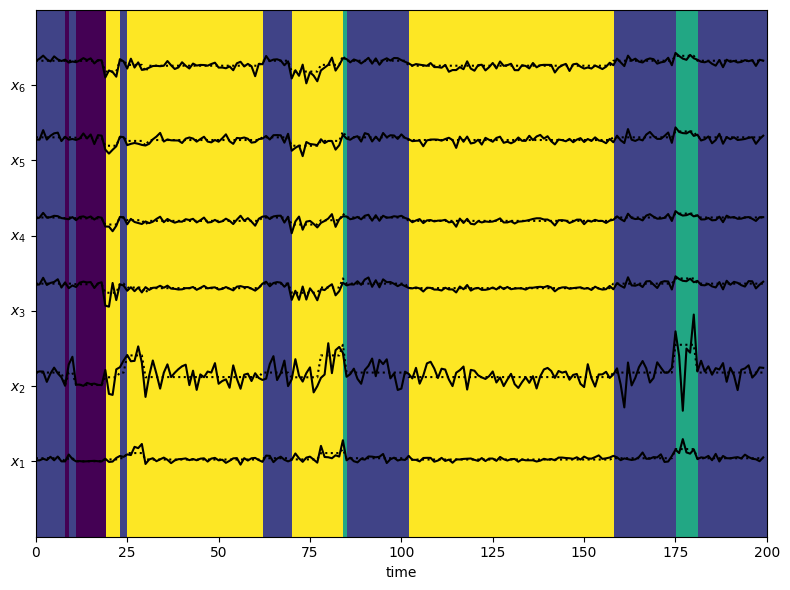

In [18]:
time_bins = 200
true_states, obs = mouse_hmm.model.sample(time_bins)
true_ll = mouse_hmm.model.log_probability(obs)
obs_dim = obs.shape[1]
lim = 1.05 * abs(obs).max()
plt.figure(figsize=(8, 6))
plt.imshow(
    true_states[None, :],
    aspect="auto",
    vmin=0,
    vmax=len(mouse_hmm.features) - 1,
    extent=(0, time_bins, -lim, (obs_dim) * lim),
)

Ey = mouse_hmm.model.observations.mus[true_states]
for d in range(obs_dim):
    plt.plot(obs[:, d] + lim * d, "-k")  # Actual observations (solid black)
    plt.plot(Ey[:, d] + lim * d, ":k")  # Expected values (dotted black)

plt.xlim(0, time_bins)
plt.xlabel("time")
plt.yticks(lim * np.arange(obs_dim), ["$x_{}$".format(d + 1) for d in range(obs_dim)])
plt.tight_layout()


In [ ]:
# Show the state and color mapping
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Create a colorbar showing the state mapping
im = ax1.imshow(
    np.arange(mouse_hmm.n_state).reshape(1, -1), cmap="viridis", aspect="auto"
)
ax1.set_xlim(-0.5, mouse_hmm.n_state - 0.5)
ax1.set_xticks(range(mouse_hmm.n_state))
ax1.set_xticklabels([f"State {i}" for i in range(mouse_hmm.n_state)], rotation=45)
ax1.set_yticks([])
ax1.set_title("State-Color Mapping")

# Show state sequence over time
ax2.plot(true_states, "o-", markersize=3, linewidth=1)
ax2.set_xlabel("Time")
ax2.set_ylabel("State")
ax2.set_title("State Sequence Over Time")
ax2.set_ylim(-0.5, mouse_hmm.n_state - 0.5)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print state statistics
print("State distribution in synthetic data:")
unique_states, counts = np.unique(true_states, return_counts=True)
for state, count in zip(unique_states, counts):
    percentage = count / len(true_states) * 100
    print(f"State {state}: {count} time bins ({percentage:.1f}%)")

In [ ]:
# Show the exact colormap used in the main visualization
fig, ax = plt.subplots(figsize=(10, 2))

# Create the same visualization as in the main plot but just for the colorbar
states_grid = np.arange(mouse_hmm.n_state).reshape(1, -1)
im = ax.imshow(
    states_grid, aspect="auto", cmap="viridis", vmin=0, vmax=len(mouse_hmm.features) - 1
)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, orientation="horizontal", pad=0.1)
cbar.set_label("Hidden State", fontsize=12)
cbar.set_ticks(range(mouse_hmm.n_state))
cbar.set_ticklabels([f"State {i}" for i in range(mouse_hmm.n_state)])

ax.set_xlim(-0.5, mouse_hmm.n_state - 0.5)
ax.set_xticks(range(mouse_hmm.n_state))
ax.set_xticklabels([f"State {i}" for i in range(mouse_hmm.n_state)])
ax.set_yticks([])
ax.set_title("Color Map for Hidden States (as used in main visualization)", fontsize=14)

plt.tight_layout()
plt.show()

Below are the mean and 95% confidence interval of some essential features during each state fit from the training data.

Below is the transition matrix of the model, fit from the training data.

In [7]:
matrix = mouse_hmm.transition_mat
annot_array = np.array([[round(item, 3) for item in row] for row in matrix])
labels = ["$S_{" + str(i + 1) + "}$" for i in range(len(matrix))]

fig, axs = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(
    matrix,
    cmap="RdBu",
    ax=axs,
    square="True",
    cbar=True,
    annot=annot_array,
    annot_kws={"size": 14},
)
axs.set_title("Transition Matrix", fontsize=25)
axs.set_xticklabels(labels)
axs.set_yticklabels(labels, rotation=0)
axs.tick_params(axis="both", which="major", labelsize=20)
plt.tight_layout()
plt.show()

TypeError: 'NoneType' object is not iterable